In [1]:
# Imports for the entire project

# Data Handling and Visualization
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine Learning and Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Suppress warnings from pandas for cleaner outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get today's date for the end date
today = datetime.today().strftime('%Y-%m-%d')

# Download S&P 500 historical data from 2003 to today
sp500 = yf.download('^GSPC', start='2003-01-20', end=today)

# Display the first few rows to verify the data
print("First five rows of the S&P 500 data:")
print(sp500.head())

# Display summary statistics for the dataset
print("\nSummary statistics of the S&P 500 data:")
print(sp500.describe())


[*********************100%***********************]  1 of 1 completed

First five rows of the S&P 500 data:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2003-01-21  901.780029  906.000000  887.619995  887.619995  887.619995   
2003-01-22  887.619995  889.739990  877.640015  878.359985  878.359985   
2003-01-23  878.359985  890.250000  876.890015  887.340027  887.340027   
2003-01-24  887.340027  887.340027  859.710022  861.400024  861.400024   
2003-01-27  861.400024  863.950012  844.250000  847.479980  847.479980   

                Volume  
Date                    
2003-01-21  1335200000  
2003-01-22  1560800000  
2003-01-23  1744550000  
2003-01-24  1574800000  
2003-01-27  1435900000  

Summary statistics of the S&P 500 data:
              Open         High          Low        Close    Adj Close  \
count  5459.000000  5459.000000  5459.000000  5459.000000  5459.000000   
mean   2193.289725  2205.551225  2180.281857  2193.733475  2193.733475   
std   

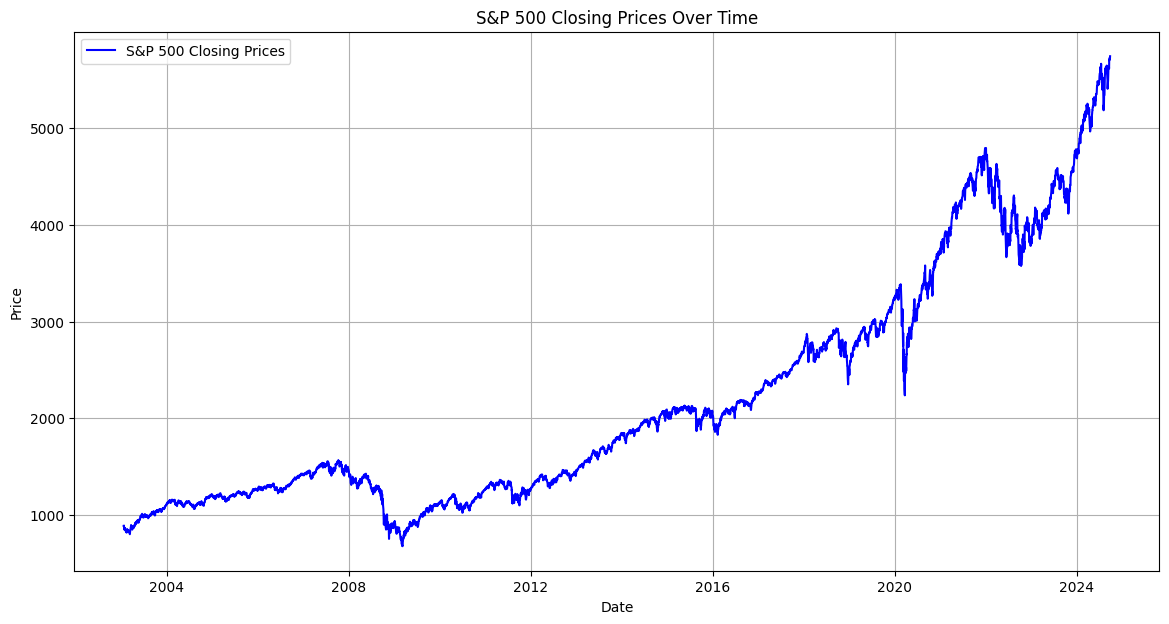

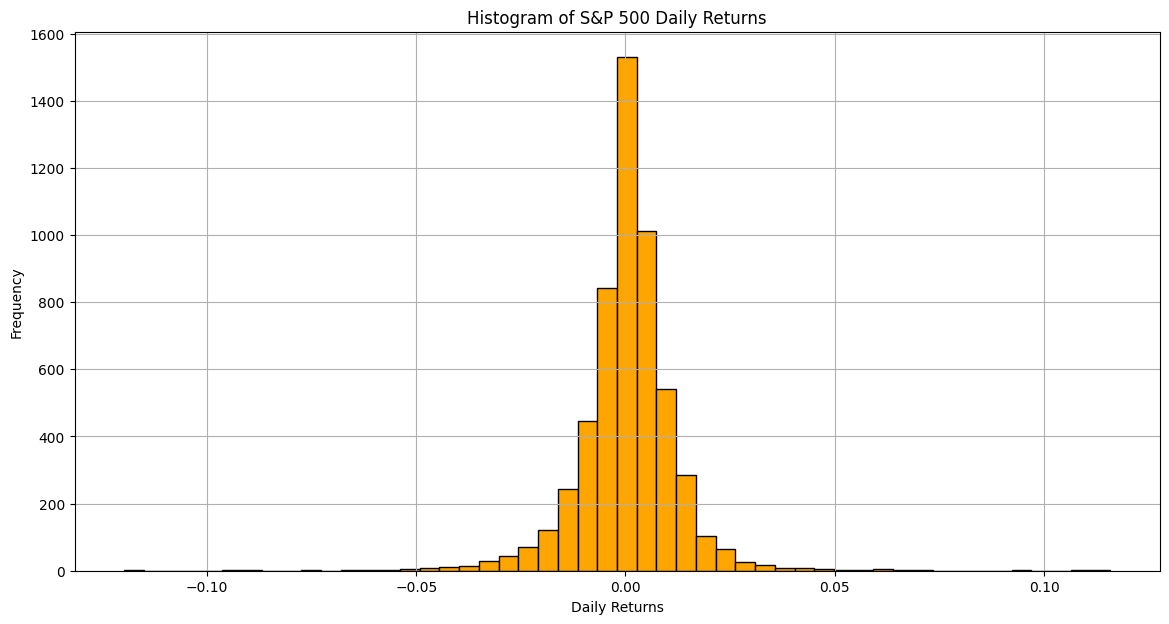

In [3]:
# 1. Plot the closing prices over time
plt.figure(figsize=(14, 7))
plt.plot(sp500['Close'], label='S&P 500 Closing Prices', color='blue')
plt.title('S&P 500 Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# 2. Calculate daily returns
sp500['Daily Returns'] = sp500['Close'].pct_change()

# Plot histogram of daily returns
plt.figure(figsize=(14, 7))
plt.hist(sp500['Daily Returns'].dropna(), bins=50, color='orange', edgecolor='black')
plt.title('Histogram of S&P 500 Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()


In [4]:
# 1. Calculate the 14-day RSI (Relative Strength Index)
delta = sp500['Close'].diff()
gain = delta.where(delta > 0, 0)  # Keep positive gains
loss = -delta.where(delta < 0, 0)  # Keep negative losses
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
sp500['RSI'] = 100 - (100 / (1 + rs))

# 2. Calculate the MACD (Moving Average Convergence Divergence)
ema_12 = sp500['Close'].ewm(span=12, adjust=False).mean()
ema_26 = sp500['Close'].ewm(span=26, adjust=False).mean()
sp500['MACD'] = ema_12 - ema_26
sp500['Signal Line'] = sp500['MACD'].ewm(span=9, adjust=False).mean()

# 3. Calculate 50-day and 200-day Moving Averages
sp500['50_MA'] = sp500['Close'].rolling(window=50).mean()
sp500['200_MA'] = sp500['Close'].rolling(window=200).mean()

# Drop rows with NaN in the new features
sp500_cleaned = sp500[['RSI', 'MACD', 'Signal Line', '50_MA', '200_MA', 'Daily Returns']].dropna()

# Display the first few rows to verify the new features
print(sp500_cleaned.head())


                  RSI      MACD  Signal Line        50_MA      200_MA  \
Date                                                                    
2003-11-03  55.971472  6.945931     6.146828  1027.125397  947.735699   
2003-11-04  53.912924  7.128931     6.343248  1028.316196  948.563849   
2003-11-05  51.073346  7.076198     6.489838  1029.417798  949.431100   
2003-11-06  62.233874  7.452020     6.682275  1030.642999  950.284650   
2003-11-07  55.609556  7.275440     6.800908  1031.650398  951.243699   

            Daily Returns  
Date                       
2003-11-03       0.007909  
2003-11-04      -0.005448  
2003-11-05      -0.001367  
2003-11-06       0.005933  
2003-11-07      -0.004575  


In [5]:
# Step 4: Model Training

# Prepare the target (y): 1 if tomorrow's return is positive, -1 if negative
sp500_cleaned['Target'] = np.where(sp500_cleaned['Daily Returns'].shift(-1) > 0, 1, -1)

# Prepare features (X) and target (y)
X = sp500_cleaned[['RSI', 'MACD', 'Signal Line', '50_MA', '200_MA']].values
y = sp500_cleaned['Target'].values

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare a dictionary of models to train and evaluate
models = {
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC()
}

# Train, predict, and evaluate all models
model_results = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results in a dictionary
    model_results[name] = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }

# Convert the results to a DataFrame for easier comparison
results_df = pd.DataFrame(model_results).T
print("\nComparison of Model Performance:")
print(results_df)


Training HistGradientBoosting...
Training RandomForest...
Training LogisticRegression...
Training SVC...

Comparison of Model Performance:
                      accuracy  precision    recall  f1-score
HistGradientBoosting  0.549430   0.544941  0.549430  0.537520
RandomForest          0.501901   0.496170  0.501901  0.495208
LogisticRegression    0.531369   0.517124  0.531369  0.391068
SVC                   0.531369   0.282353  0.531369  0.368759



Final Model Comparison:
                      accuracy  precision    recall  f1-score
HistGradientBoosting  0.549430   0.544941  0.549430  0.537520
RandomForest          0.501901   0.496170  0.501901  0.495208
LogisticRegression    0.531369   0.517124  0.531369  0.391068
SVC                   0.531369   0.282353  0.531369  0.368759


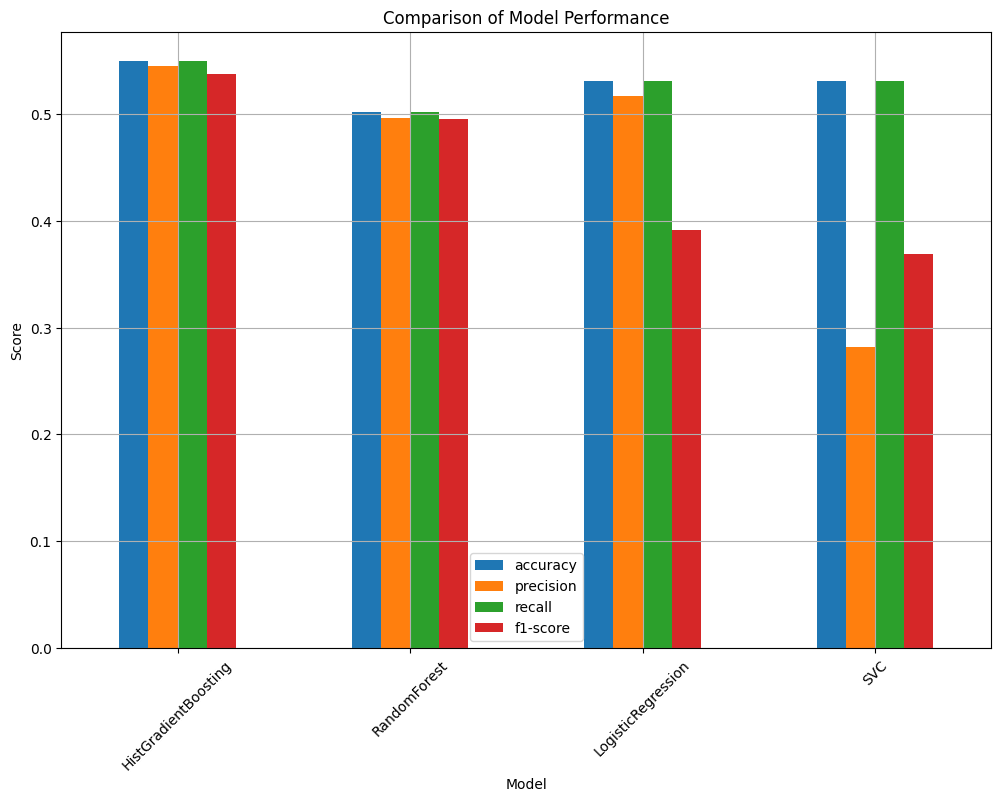

In [6]:
# Display the comparison of model performance
print("\nFinal Model Comparison:")
print(results_df)

# Plot the performance of each model
results_df[['accuracy', 'precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Model Performance')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [7]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],     # Number of trees in the forest
    'max_depth': [5, 10, 15],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]        # Minimum number of samples required at a leaf node
}

# Initialize GridSearchCV with the RandomForest model and parameter grid
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Calculate accuracy and classification report for the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)

print(f"Tuned Model Accuracy: {accuracy_tuned:.4f}")
print("\nClassification Report for the Tuned Model:")
print(report_tuned)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


288.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
288.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
288.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
288.69s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
288.86s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
289.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
289.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
289.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s


289.61s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
289.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s


289.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s


290.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s


290.59s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
290.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s


290.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s


291.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
291.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s


291.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
291.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s


291.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s


292.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1